# createImageAvailabilityGraphic - Rio Grande Valley
Code to create a graphic of available satellite images from several typical satellite-sensors, given a user-defined region and time period of interest.

## 0. Imports

In [25]:
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geemap
import importlib
import ImageAvailabilityVisualisation as viz
importlib.reload(viz)
import ImageAvailabilityInfos as info
importlib.reload(info)

<module 'ImageAvailabilityInfos' from 'C:\\Users\\alexa\\Documents\\GitHub\\satelliteImageAvailability\\ImageAvailabilityInfos.py'>

### Import and authenticate GEE

In [2]:
import ee

In [3]:
ee.Authenticate()

Enter verification code:  4/1AfJohXkSEP56Cr35szk2PcIpVxP6JmDyJ9rEDM9n-X8xkqY9UUDO_l2gLzQ



Successfully saved authorization token.


In [4]:
ee.Initialize()

## 1. Define region and time of interest

### Region of Interest
This is easiest to do by calling a FeatureCollection of an asset (i.e. shapefile or geojson) already uploaded to GEE.

In [37]:
# Define the region of interest - using shapefile for Rio_Grande
roi = ee.FeatureCollection("users/alex-saunders/Rio_Grande") # will need to upload shapefile to assets in your own GEE account, or we switch this for shapefile to reside in a earth engine cloud project
# Get number of elements in the region of interest file (e.g., could have multiple watersheds / admin areas in the same shapefile)
n = roi.size().getInfo()

__Choose to get image availability for each geometry within the feature collection or dissolve the geometries and get a single image availability__

If you want to retain all original geometries, do not run the below

In [38]:
# Dissolve to one element
roi = ee.FeatureCollection(roi.geometry().dissolve())
n = roi.size().getInfo()

### Time of interest
__Guidance:__
* Currently define the "central date" you want to look for and the number of days either side.
* If preferred can manually specify start and end date as strings in correct format - see "options to edit in below code"
* Can provide multiple dates and multiple images will be created.

In [46]:
# Define the dates of interest and the number of days either side of the target date for whcih to create the visualization
# Add multiple dates to search for multiple time periods / events at once
dates = ['6/23/2018'] 
dates = [datetime.datetime.strptime(item,'%m/%d/%Y') for item in dates]
daysBeforeAfter = 12 # days

### Optional: manually upload a CSV with cloud cover for Planet images, extracted manually from Planet Explorer
Since we know that currently, the Planet data does not return properly using the API (for given dates?), it is sensible to manually create a CSV file of Planet images with their cloud cover and % area coverage from Planet explorer.

In [47]:
planetCSV = 'Z:/media/mule/users/alexsaunders/FloodJusticeData/planet/rgv.csv'

## 2. Create graphic of image availability

__Enter your Planet API key__

In [48]:
planetKey = 'PLAK4ce6a11d243242cbb977d14fd9f456ab'

### User options to edit in below code:
* __Replace planetCSV=None__ with location of Planet csv file if want to include it, otherwise the default Planet API will be used-this can give erroneous results
* __Replace includeS2TOA=False__ with includeS2TOA=True if want to include Sentinel-2 top of atmosphere data if there is no surface reflectance data available - S2 SR data tends to start around end of 2018, whereas TOA data is available from roughly 2015-16 onwards
* __Replace startDateStr and endDateStr__ if you want to manually define start and end dates, rather than rely on the centre dates and buffer days created above

S2 : No images for the TOI and ROI
S2 TOA : Success in getting the FilteredCollection with image info
S1 : Success in getting the FilteredCollection with image info
MODIS : Success in getting the FilteredCollection with image info
L7 : Success in getting the FilteredCollection with image info
L8 : Success in getting the FilteredCollection with image info
L9 : No images for the TOI and ROI


C:\Users\alexa\Documents\GitHub\satelliteImageAvailability\ImageAvailabilityVisualisation.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


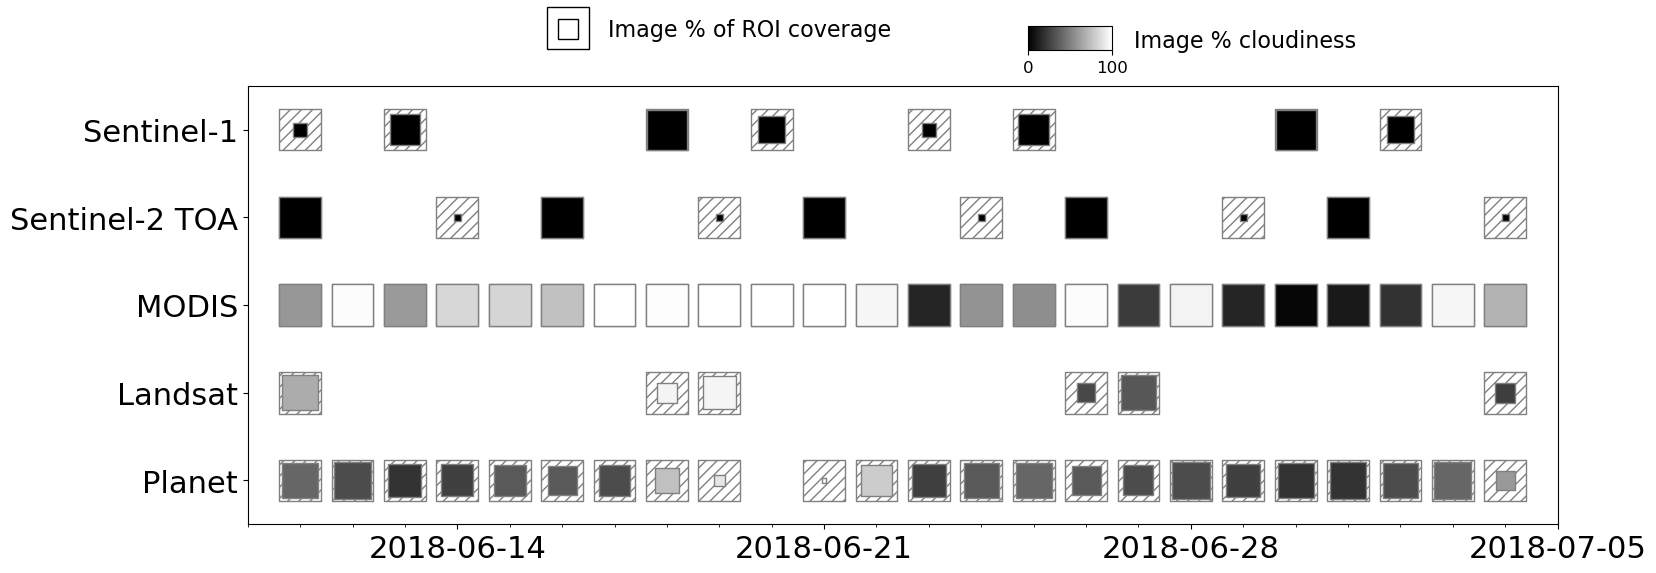

In [49]:
# Loop through event dates - will produce as many images as there are event dates
for date in dates:
    
    # Loop through elements of the ROI (if more than one, otherwise will just create a single output for the single ROI)
    for k in range(n): 
        
        # Get geometry as geometry format, from the Feature Collection
        geometry = ee.Feature(roi.toList(n).get(k)).geometry() 
        
        # Create start and end date in required format for GEE search
        startDateStr = (date - timedelta(days=daysBeforeAfter)).strftime('%Y-%m-%d')
        endDateStr = (date + timedelta(days=daysBeforeAfter)).strftime('%Y-%m-%d')
        
        # If you want to use manually defined start and end rather than a central date with a days before / after, specify as string instead
        # startDateStr = '2017-08-01'
        # endDateStr = '2017-09-01'
        
        # Create figure
        # fig = viz.showImageAvailability(startDateStr, endDateStr, geometry, planetKey, planetCSV=None, includeS2TOA=False) 
        fig = viz.showImageAvailability(startDateStr, endDateStr, geometry, planetKey, planetCSV=planetCSV, includeS2TOA=True) 
        
        # Save figure to png
        fig.savefig('imageAvailabilityFigure.png')

### NOTE
If you want to get a dataframe of the actual data that creates the graphic, you can run the below

In [50]:
# Get dataframes of info
date_list_df, sentinel2_df, sentinel1_df, modis_terra_df, landsat7_df, landsat8_df, landsat9_df, PlanetInfoDF, s2TOAFlag = info.GetDataFrames(startDateStr, endDateStr, geometry, planetKey, planetCSV=None, includeS2TOA=False)

S2 : No images for the TOI and ROI
S2 TOA : Success in getting the FilteredCollection with image info
S1 : Success in getting the FilteredCollection with image info
MODIS : Success in getting the FilteredCollection with image info
L7 : Success in getting the FilteredCollection with image info
L8 : Success in getting the FilteredCollection with image info
L9 : No images for the TOI and ROI


In [51]:
sentinel1_df

,dateTime,pctArea,pctCloud
date,,,
2018-06-11,2018-06-11,33.349511,0.0
2018-06-13,2018-06-13,73.391713,0.0
2018-06-18,2018-06-18,95.534290,0.0
2018-06-20,2018-06-20,65.130140,0.0
2018-06-23,2018-06-23,33.377484,0.0
2018-06-25,2018-06-25,73.428705,0.0
2018-06-30,2018-06-30,95.503831,0.0
2018-07-02,2018-07-02,65.113765,0.0


In [52]:
PlanetInfoDF

,pctArea,pctCloud
date,,
2018-06-18,24.562785,65.511587
2018-06-22,1.785374,37.670322
2018-06-24,19.264617,22.110375
2018-06-26,8.602336,2.029493
2018-07-02,22.062440,18.185944
2018-07-03,56.764609,23.135506
2018-07-04,52.476455,20.463697
